## Analysis of Covid-19 positive rate variations among postcode areas in NYC

##  Introduction
Positive Covid rates vary greatly among different areas in New York City. By using demographic data together with Foursquare venue location data, we may get some clues to explain the variations.

## Data Acquisition
In this section, I will explain all types of data I would consider in this study, and the resources to get them. Since I want to compare the posiivie rate variations in different areas, the data I need will be exhibited by small areas, like community neighborhood or zip code area. I choose to use zip code area data for this study.


#### Covid data
NYC Covid-19 data is essential as the final target to understand. Covid data can be accessed through the website of __NYC Department of Health and Mental Hygiene__. The department has a github account to update the data daily: https://github.com/nychealth/coronavirus-data. The data show covid positive rates in each postal code area.

#### Demographic data
Population density could possibly cause different virus spreading rates. Also, since different age groups have their different social activity habits and show quite different reaction to the pandemic, it's interesting to know if the age percentage has played a role to cause different covid positive rates. The information can be found on data.census.gov and was collected from __American Community Survey__ 2018.

`uszipcode` is a python zipcode database. Information like the area of the post code areas, latitude and longitude can be easily loaded from the library. The library also offers economic information like median household income, which can also be used in our analysis.


#### Venue location data
For the venue data, first, I am curious to know if more restaurants in an area is related to a higher covid rate.

Second, different types and different quantities of venues can be potential reasons to cause higher or lower rates. With the venue information from __Foursquare__, we can cluster the venues based on zip code, and see if the cluster is related to different covid rates.

## Analysis

In this part, let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's import all the datasets:

#### Import all the libraries:

In [54]:
import numpy as np 

# library for data analsysis
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import json 
import requests

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium 

# get basic demographic info for each postal area
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)

#### Import Covid data:

In [2]:
covid_data = pd.read_csv('data-by-modzcta.csv')
covid_data.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,433,1837.62,23563.03,26,110.34,6.04,7165
1,10002,Chinatown/Lower East Side,Manhattan,1305,1700.21,76755.41,161,209.76,8.64,15105
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,525,975.81,53801.62,34,63.20,4.47,11750
3,10004,Financial District,Manhattan,39,1068.32,3650.61,1,27.39,4.83,807
4,10005,Financial District,Manhattan,91,1083.84,8396.11,2,23.82,4.75,1915


Clean up the data by removing unnecessary columns and changing column names:

In [3]:
covid_df = covid_data[['MODIFIED_ZCTA','PERCENT_POSITIVE']]
covid_df = covid_df.rename(columns={'MODIFIED_ZCTA':'ZipCode','PERCENT_POSITIVE':'CovidPercentagePositive'})
covid_df.head()

,ZipCode,CovidPercentagePositive
0,10001,6.04
1,10002,8.64
2,10003,4.47
3,10004,4.83
4,10005,4.75


We can see the distribution on the map:

In [4]:
nyc_df = covid_df[['ZipCode','CovidPercentagePositive']]

#change zipcode to str to match the format from json file:
nyc_str = nyc_df[['ZipCode', 'CovidPercentagePositive']]
nyc_str['ZipCode'] =nyc_str['ZipCode'].astype(str)


#import json file with zip code area information
with open('nyc_zip.txt') as json_file:
    nyc_zipmap = json.load(json_file)

# create a plain map centered on NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11, tiles='Stamen Toner')

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
nyc_map.choropleth(
    geo_data= nyc_zipmap,
    data=nyc_str,
    columns=['ZipCode', 'CovidPercentagePositive'],
    key_on='feature.properties.postalCode', #always starts with feature instead of features
    fill_color='YlOrRd', 
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Covid Positive Rates'
)
nyc_map.save('nyc_covid_map.html')
# display map
nyc_map



We can see the great differences of Covid positive rates for different postal code areas.
Then, we import some demographic, geographic and economic information from `uszipcode` database:

In [11]:
nyc_df = covid_df[['ZipCode','CovidPercentagePositive']]
pd = []
rm = []
ic = []
lat = []
lng = []
for index, row in nyc_df.iterrows():
    zipcode  = row['ZipCode'] 
    demoinfo = search.by_zipcode(str(int(zipcode)))
    
    pd = pd + [demoinfo.population_density]
    rm = rm + [np.sqrt(demoinfo.land_area_in_sqmi)/2*1609] #estimate radius and change the unit to meters
    ic = ic + [demoinfo.median_household_income]
    lat = lat + [demoinfo.lat]
    lng = lng + [demoinfo.lng]
    
nyc_df.insert(1, "Latitude", lat, True)
nyc_df.insert(2, "Longitude", lng, True)
nyc_df.insert(3, "Radius", rm, True)
nyc_df.insert(4, "PopulationDensity", pd, True)
nyc_df.insert(5, "Income", ic, True)

nyc_df['PopulationDensity'] = nyc_df['PopulationDensity'].astype('int64')

nyc_df.head()

,ZipCode,Latitude,Longitude,Radius,PopulationDensity,Income,CovidPercentagePositive
0,10001,40.750,-73.990,633.463933,33959,81671,6.04
1,10002,40.720,-73.990,754.687896,92573,33218,8.64
2,10003,40.730,-73.990,612.688946,97188,92540,4.47
3,10004,40.700,-74.020,602.032674,5519,129313,4.83
4,10005,40.705,-74.005,212.850693,97048,124670,4.75


As for the age percentage information for each zip code area, we have to import from Aumerican Community Survey on data.census.gov :

Youth is defined as people younger than 18 years old, and senior people are older than 65.


Let's combine the data to nyc_df dataframe:

In [14]:
age_df = pd.read_csv('age_dataframe.csv')
#zipcode index is the same for nyc_df and age_df
nyc_df.insert(6, "PercentageYouth", age_df['YouthRatio'], True)
nyc_df.insert(7, "PercentageSenior", age_df['SeniorRatio'], True)
nyc_df.head()

,ZipCode,Latitude,Longitude,Radius,PopulationDensity,Income,PercentageYouth,PercentageSenior,CovidPercentagePositive
0,10001,40.750,-73.990,633.463933,33959,81671,8.7,14.8,6.04
1,10002,40.720,-73.990,754.687896,92573,33218,13.3,21.1,8.64
2,10003,40.730,-73.990,612.688946,97188,92540,7.1,11.8,4.47
3,10004,40.700,-74.020,602.032674,5519,129313,11.4,7.5,4.83
4,10005,40.705,-74.005,212.850693,97048,124670,12.5,1.3,4.75


In [15]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ZipCode                  177 non-null    int64  
 1   Latitude                 177 non-null    float64
 2   Longitude                177 non-null    float64
 3   Radius                   177 non-null    float64
 4   PopulationDensity        177 non-null    int64  
 5   Income                   177 non-null    int64  
 6   PercentageYouth          177 non-null    float64
 7   PercentageSenior         177 non-null    float64
 8   CovidPercentagePositive  177 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 12.6 KB


In [16]:
cor_matrix =nyc_df[['Radius',"PopulationDensity",'Income','PercentageYouth','PercentageSenior']].corr()
cor_matrix

,Radius,PopulationDensity,Income,PercentageYouth,PercentageSenior
Radius,1.000000,-0.604117,-0.261077,0.337497,0.198124
PopulationDensity,-0.604117,1.000000,0.042710,-0.266394,-0.076080
Income,-0.261077,0.042710,1.000000,-0.405369,0.040974
PercentageYouth,0.337497,-0.266394,-0.405369,1.000000,-0.314499
PercentageSenior,0.198124,-0.076080,0.040974,-0.314499,1.000000


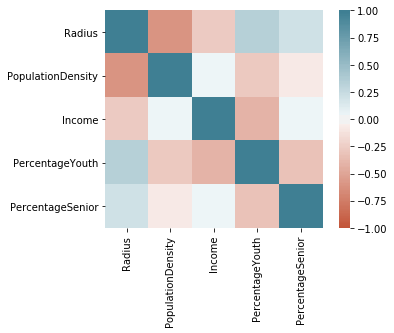

In [17]:
import seaborn as sns
ax = sns.heatmap(
    cor_matrix,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

Measure the linear correlation between features and Covid rates:

In [18]:
from scipy import stats

pearson_coef, pvalue = stats.pearsonr(nyc_df['Income'],nyc_df['CovidPercentagePositive'])
print('Income: pearson_coef: ', pearson_coef, 'P value: ', pvalue)
pearson_coef, pvalue = stats.pearsonr(nyc_df['PopulationDensity'],nyc_df['CovidPercentagePositive'])
print('PopulationDensity: pearson_coef: ', pearson_coef, 'P value: ', pvalue)

c, p = stats.pearsonr(nyc_df['PercentageYouth'],nyc_df['CovidPercentagePositive'])
print('PercentageYouth: pearson_coef: ', c, 'P value', p)
c,p = stats.pearsonr(nyc_df['PercentageSenior'],nyc_df['CovidPercentagePositive'])
print('PercentageSenior: pearson_coef: ', c, 'P value', p)

Income: pearson_coef:  -0.5281829160070944 P value:  4.182406775881553e-14
PopulationDensity: pearson_coef:  -0.4378012728323962 P value:  1.1034100191394924e-09
PercentageYouth: pearson_coef:  0.601788236000838 P value 8.1108317146544e-19
PercentageSenior: pearson_coef:  0.0014303021928728059 P value 0.984925571500023


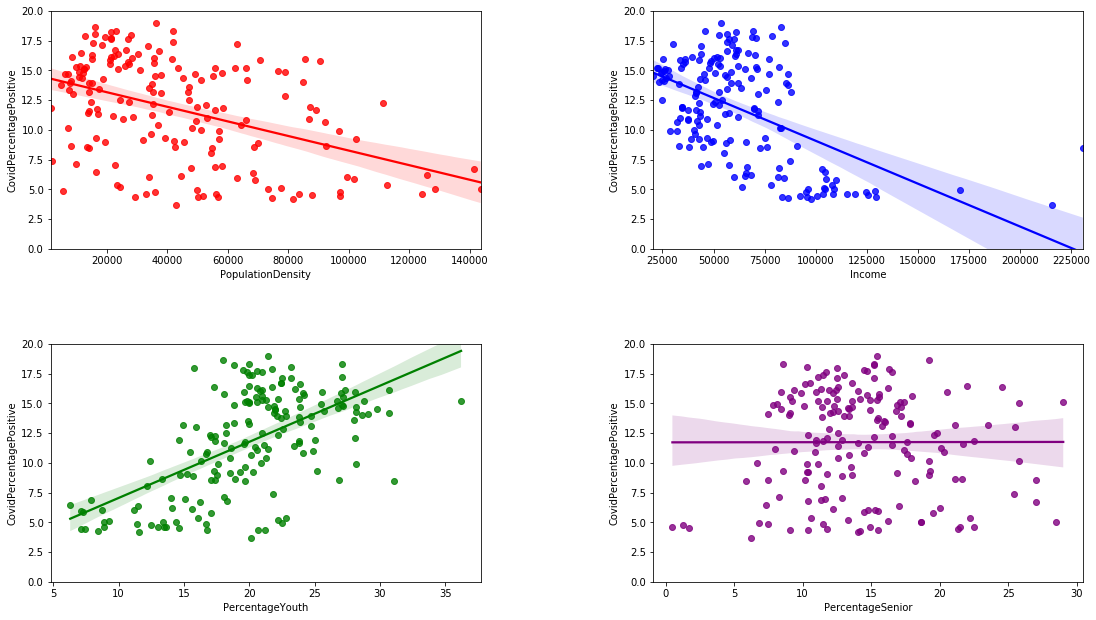

In [19]:
# create figure
fig = plt.figure() 
fig.set_size_inches(18.5, 10.5)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax0 = fig.add_subplot(2, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(2, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). 
ax2 = fig.add_subplot(2, 2, 3) 
ax3 = fig.add_subplot(2, 2, 4)

ax0.set_ylim(0,20)
ax1.set_ylim(0,20)
ax2.set_ylim(0,20)
ax3.set_ylim(0,20)

# Subplot 1: 
sns.regplot(x='PopulationDensity', y='CovidPercentagePositive', data=nyc_df, ax = ax0,color = 'red')


# Subplot 2: 
sns.regplot(x='Income', y='CovidPercentagePositive', data=nyc_df, ax = ax1, color = 'blue')


# Subplot 3: 
sns.regplot(x='PercentageYouth', y='CovidPercentagePositive', data=nyc_df, ax = ax2, color = 'green')


# Subplot 4: 
sns.regplot(x='PercentageSenior', y='CovidPercentagePositive', data=nyc_df, ax = ax3, color = 'purple')

plt.show()

To import the restaurant information, we will need to use Foursquare:

In [20]:
CLIENT_ID = 'ORFGR1PWESGLTSQAX22WEFLKIWR5VZ4IF3TXIRKCM3NBUEBI' # Foursquare ID
CLIENT_SECRET = 'VMUZ0TBHVZ5OBGV5FFYBMDPNC1PLBPG5NKODGA0AVLLKJM0J' #  Foursquare Secret
VERSION = '20200801' # Foursquare API version

LIMIT = 100
food=[]
for index, row in nyc_df.iterrows():
    latitude = row['Latitude'] 
    longitude = row['Longitude']
    radius = row['Radius']
    
    url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json()
   
    food = food + [results['response']['totalResults']/np.square(radius/1609*2)]

nyc_df.insert(8, "RestaurantDensity", food, True)

nyc_df.head()

,ZipCode,Latitude,Longitude,Radius,PopulationDensity,Income,PercentageYouth,PercentageSenior,RestaurantDensity,CovidPercentagePositive
0,10001,40.750,-73.990,633.463933,33959,81671,8.7,14.8,280.645161,6.04
1,10002,40.720,-73.990,754.687896,92573,33218,13.3,21.1,278.409091,8.64
2,10003,40.730,-73.990,612.688946,97188,92540,7.1,11.8,332.758621,4.47
3,10004,40.700,-74.020,602.032674,5519,129313,11.4,7.5,19.642857,4.83
4,10005,40.705,-74.005,212.850693,97048,124670,12.5,1.3,200.000000,4.75


RestaurantDensity: pearson_coef:  -0.6672971026043092 P value 3.618796971074839e-24


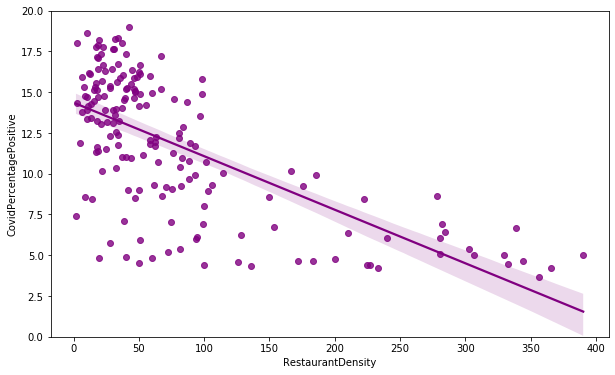

In [23]:
c,p = stats.pearsonr(nyc_df['RestaurantDensity'],nyc_df['CovidPercentagePositive'])
print('RestaurantDensity: pearson_coef: ', c, 'P value', p)

#plot the correlation figure:
fig = plt.figure() # create figure
fig.set_size_inches(10, 6)
ax = fig.add_subplot(111)
ax.set_ylim(0,20)

# Subplot: 
sns.regplot(x='RestaurantDensity', y='CovidPercentagePositive', data=nyc_df, ax = ax, color = 'purple')


plt.show()

For venue data, we adopted Foursquare to collect the information:

In [27]:
def getNearbyVenues(zipcode, latitudes, longitudes, radius):
    
    venues_list=[]
    for zipcode,lat, lng, radius in zip(zipcode, latitudes, longitudes,radius):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode', 
                  'Venue',  
                  'Venue Category']
    
    return(nearby_venues)
nyc_venues = getNearbyVenues(zipcode=nyc_df['ZipCode'], latitudes=nyc_df['Latitude'], longitudes=nyc_df['Longitude'],radius = nyc_df['Radius'])

In [60]:
nyc_venues.head(5)

,ZipCode,Venue,Venue Category
0,10001,Louis Vuitton,Boutique
1,10001,Victoria's Secret,Lingerie Store
2,10001,Delta Sky360° Club,Lounge
3,10001,Krispy Kreme Doughnuts,Donut Shop
4,10001,Wafels & Dinges Cabana,Snack Place


In [28]:
agg_venue_count = nyc_venues.groupby(['Venue Category'])['Venue Category'].agg(['count']).rename(columns={'count':'venue_count'})
sorted_venue_count = agg_venue_count.sort_values(by=['venue_count'], ascending=False)
print(sorted_venue_count.shape)
sorted_venue_count.head(10)

(448, 1)


,venue_count
Venue Category,
Pizza Place,631
Coffee Shop,364
Italian Restaurant,334
Deli / Bodega,325
Bar,305
Bakery,289
Chinese Restaurant,280
Donut Shop,276
Sandwich Place,247


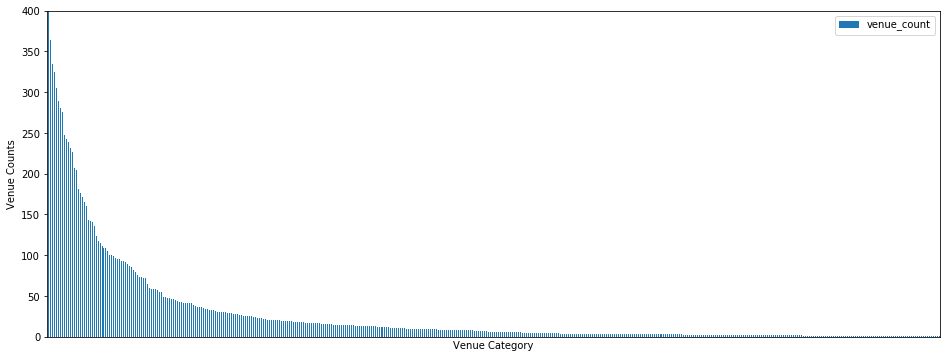

In [29]:
sorted_venue_count.plot.bar(figsize=(16, 6))
plt.xticks([])
plt.ylim(0, 400)
plt.ylabel('Venue Counts')
plt.show()


In [30]:
## Collapse 
combined_venues = nyc_venues.copy()

combined_venues.loc[combined_venues['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'] = 'Restaurant'
combined_venues.loc[combined_venues['Venue Category'].str.contains('Museum', case=False), 'Venue Category'] = 'ArtAndMusic'
combined_venues.loc[combined_venues['Venue Category'].str.contains('Bar', case=False), 'Venue Category'] = 'Bar'


combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Steakhouse','Diner'],'Restaurant')
combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Paper / Office Supplies Store','Hardware Store','Laundromat',\
                                                                               'Optical Shop','Pharmacy','Mobile Phone Shop','Shipping Store','Salon / Barbershop'],'NecessitiesStore')

combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Coffee Shop','Café','Smoke Shop','Tea Room','Bakery'],'Cafe')
combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['School','High School','Candy Store','Kids Store','Zoo','Playground','Ice Cream Shop','Comic Shop',\
                                                                               'Snack Place','Frozen Yogurt Shop','Toy / Game Store','Video Game Store'],'KidsPlace')
combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Deli / Bodega','Flower Shop',\
                                                                               'Convenience Store','Gift Shop'],'ConvenientStore')
combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Grocery Store','Supermarket'],'Grocery')
combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Park','Skate Park','Monument / Landmark','Lake','Event Space','Historic Site','Garden','Pool','Soccer Field',\
                                                                               'Track','Basketball Court','Intersection','Beach','Farmers Market','Market',\
                                                                               'Scenic Lookout','Dog Run','Tennis Stadium','Trail','Golf Course'],'OutdoorPlace')
combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Sandwich Place','Juice Bar','Donut Shop','Wings Joint','Salad Place','Food & Drink Shop','Hot Dog Joint','Food Court',\
                                                                               'Pizza Place','Food','Fast Food Restaurant','Food Truck','Bagel Shop','Gourmet Shop',\
                                                                               'BBQ Joint','Bubble Tea Shop','Dessert Shop','Fried Chicken Joint','Taco Place',\
                                                                               'Burger Joint','Breakfast Spot'],'FastFood')
combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Post Office','Bank'],'Facility')
combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Thrift / Vintage Store','Jewelry Store','Cosmetics Shop','Department Store','Record Shop',\
                                                                               'Men\'s Store','Mattress Store','Clothing Store','Discount Store','Boutique','Women\'s Store',\
                                                                               'Shoe Store','Plaza','Supplement Shop','Shopping Mall'],'RetailStore')
combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Jazz Club','Brewery','Speakeasy','Lounge','Pub','Gastropub','Nightclub','Beer Garden'],'Bar')
combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Gym / Fitness Center','Gym','Pilates Studio','Spa','Tennis Court','Athletics & Sports',\
                                                                               'Boxing Gym','Yoga Studio','Dance Studio','Martial Arts School','Cycle Studio',\
                                                                               'Baseball Field','Climbing Gym','Gymnastics Gym'],'IndoorGym')
combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Bus Station','Harbor / Marina','Metro Station','Bus Stop','Bus Line',\
                                                                               'Rental Car Location','Train Station','Boat or Ferry','Airport Lounge',\
                                                                               'Airport Tram','Gas Station'],'Transportation')
combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Theater','Indie Theater','Movie Theater','Concert Hall','Music Store',\
                                                                               'Art Gallery','History Museum','Music Venue','Performing Arts Venue','Arts & Crafts Store','Bookstore'],'ArtAndMusic')
combined_venues['Venue Category'] = combined_venues['Venue Category'].replace(['Smoke Shop','Liquor Store','Beer Store','Wine Shop','Video Store','Electronics Store','Nail Salon','Pet Store',\
                                                                               'Sporting Goods Shop','Health & Beauty Service','Furniture / Home Store'],'LifeStyleStore')

In [31]:
venue_counts = combined_venues.groupby(['Venue Category'])['Venue Category'].agg(['count']).sort_values(by=['count'], ascending=False)
venue_counts_minor = venue_counts[venue_counts['count'] <= 12]
venue_counts_major = venue_counts[venue_counts['count'] > 12]

majors= list(venue_counts_major.index)
minors= list(venue_counts_minor.index)

combined_venues = combined_venues[~combined_venues['Venue Category'].isin(minors)]
combined_venues.reset_index(inplace = True,drop=True)
combined_venues.head(5)

,ZipCode,Venue,Venue Category
0,10001,Louis Vuitton,RetailStore
1,10001,Delta Sky360° Club,Bar
2,10001,Krispy Kreme Doughnuts,FastFood
3,10001,Wafels & Dinges Cabana,KidsPlace
4,10001,Bikram Yoga Herald Square,IndoorGym


In [32]:
majors

['Restaurant',
 'FastFood',
 'Bar',
 'Cafe',
 'RetailStore',
 'OutdoorPlace',
 'IndoorGym',
 'KidsPlace',
 'ConvenientStore',
 'NecessitiesStore',
 'Grocery',
 'LifeStyleStore',
 'Transportation',
 'ArtAndMusic',
 'Facility',
 'Hotel']

In [33]:
# one hot encoding
nyc_onehot = pd.get_dummies(combined_venues[['Venue Category']], prefix="", prefix_sep="")

# add zipcode column back to dataframe
nyc_onehot['ZipCode'] = combined_venues['ZipCode']

# move ZipCode column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,ZipCode,ArtAndMusic,Bar,Cafe,ConvenientStore,Facility,FastFood,Grocery,Hotel,IndoorGym,KidsPlace,LifeStyleStore,NecessitiesStore,OutdoorPlace,Restaurant,RetailStore,Transportation
0,10001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,10001,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10001,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,10001,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,10001,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Group in zipcode area and count the average number:

In [34]:
nyc_zip_grouped = nyc_onehot.groupby('ZipCode').sum().reset_index()
nyc_zip_grouped.head(5)

,ZipCode,ArtAndMusic,Bar,Cafe,ConvenientStore,Facility,FastFood,Grocery,Hotel,IndoorGym,KidsPlace,LifeStyleStore,NecessitiesStore,OutdoorPlace,Restaurant,RetailStore,Transportation
0,10001,4,4,10,2,0,15,1,6,13,1,1,0,2,27,9,0
1,10002,3,16,8,2,0,10,1,4,3,6,3,1,1,32,3,0
2,10003,3,6,10,1,0,12,4,2,8,6,6,0,0,37,2,0
3,10004,0,1,1,0,0,3,0,0,1,4,0,0,6,5,0,5
4,10005,1,0,0,0,0,2,0,0,1,1,1,0,1,5,1,1


In [35]:
#Average venue based on area population: number of businese venues per 100,000 person
divisor = nyc_df['PopulationDensity'].div(100000)
venue_averaged = nyc_zip_grouped.drop(['ZipCode'], 1).div(divisor, axis = 0) 

venue_averaged.head(5)


,ArtAndMusic,Bar,Cafe,ConvenientStore,Facility,FastFood,Grocery,Hotel,IndoorGym,KidsPlace,LifeStyleStore,NecessitiesStore,OutdoorPlace,Restaurant,RetailStore,Transportation
0,11.778910,11.778910,29.447275,5.889455,0.0,44.170912,2.944727,17.668365,38.281457,2.944727,2.944727,0.000000,5.889455,79.507642,26.502547,0.000000
1,3.240686,17.283657,8.641829,2.160457,0.0,10.802286,1.080229,4.320914,3.240686,6.481371,3.240686,1.080229,1.080229,34.567314,3.240686,0.000000
2,3.086801,6.173602,10.289336,1.028934,0.0,12.347203,4.115734,2.057867,8.231469,6.173602,6.173602,0.000000,0.000000,38.070544,2.057867,0.000000
3,0.000000,18.119224,18.119224,0.000000,0.0,54.357673,0.000000,0.000000,18.119224,72.476898,0.000000,0.000000,108.715347,90.596122,0.000000,90.596122
4,1.030418,0.000000,0.000000,0.000000,0.0,2.060836,0.000000,0.000000,1.030418,1.030418,1.030418,0.000000,1.030418,5.152090,1.030418,1.030418


In [36]:
factor_mean = venue_averaged.mean(axis=0).to_list()
normalized_venues = venue_averaged.div(factor_mean, axis='columns')
normalized_venues.head()

,ArtAndMusic,Bar,Cafe,ConvenientStore,Facility,FastFood,Grocery,Hotel,IndoorGym,KidsPlace,LifeStyleStore,NecessitiesStore,OutdoorPlace,Restaurant,RetailStore,Transportation
0,1.730946,0.672791,1.667640,0.492666,0.0,0.969051,0.322551,9.290035,3.194094,0.261548,0.341278,0.000000,0.324368,1.116675,1.841490,0.000000
1,0.476228,0.987213,0.489399,0.180727,0.0,0.236988,0.118323,2.271939,0.270393,0.575669,0.375578,0.095963,0.059495,0.485493,0.225174,0.000000
2,0.453615,0.352625,0.582699,0.086073,0.0,0.270881,0.450817,1.082028,0.686810,0.548333,0.715487,0.000000,0.000000,0.534696,0.142988,0.000000
3,0.000000,1.034939,1.026117,0.000000,0.0,1.192535,0.000000,0.000000,1.511816,6.437323,0.000000,0.000000,5.987619,1.272411,0.000000,8.175210
4,0.151423,0.000000,0.000000,0.000000,0.0,0.045212,0.000000,0.000000,0.085975,0.091521,0.119420,0.000000,0.056751,0.072360,0.071597,0.092983


Use k-means clustering method to cluster the venues:

Text(0.5, 1.0, 'SSE for different cluster numbers')

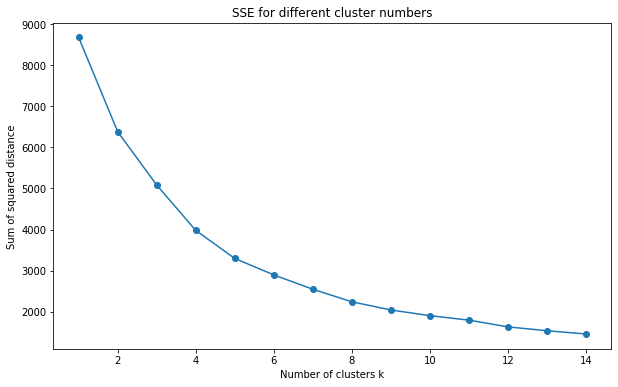

In [37]:
# First, use elbow method to find the best cluster number
# error sum of squares
sse = []
ls_k = list(range(1, 15))
# set number of clusters
for i in range(1,15):
    kclusters = i
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(normalized_venues)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(ls_k, sse, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distance')
plt.title('SSE for different cluster numbers')

In [44]:
nyc_clustering = nyc_zip_grouped.drop(['ZipCode'], 1)

kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_clustering)

We can briefly check the relation between cluster distribution and covid rates:

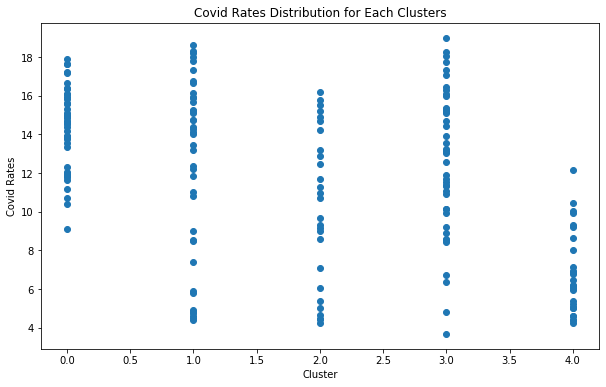

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(kmeans.labels_, nyc_df['CovidPercentagePositive'])
plt.xlabel('Cluster')
plt.ylabel('Covid Rates')
plt.title('Covid Rates Distribution for Each Clusters')
plt.show()

We can see different clusters show different covid rate trends. To better have a look at the distributions, we can plot the data in a histogram plot. 

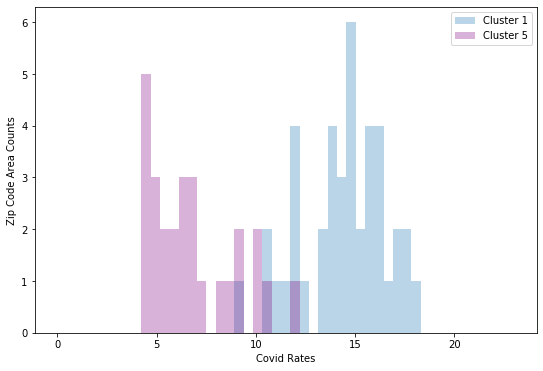

In [56]:
#for cluster 1
group1 = nyc_df[['CovidPercentagePositive']]
group1 = group1[kmeans.labels_==0]
group1.reset_index(inplace = True, drop = True)
i = group1['CovidPercentagePositive']


#for cluster 5
group5 = nyc_df[['CovidPercentagePositive']]
group5 = group5[kmeans.labels_==4]
group5.reset_index(inplace = True, drop = True)
j = group5['CovidPercentagePositive']

bins = np.linspace(0, 23)
plt.figure(figsize=(9, 6))
plt.hist(i, bins, alpha=0.3, label='Cluster 1')
plt.hist(j, bins, alpha=0.3, label='Cluster 5',color = 'purple')

plt.legend(loc='upper right')
plt.xlabel('Covid Rates')
plt.ylabel('Zip Code Area Counts')
plt.show()

In [49]:
#pick data from each clusters
group1_venue = nyc_zip_grouped[kmeans.labels_==0]
group1_venue['PopulationDensity'] = nyc_df['PopulationDensity'][kmeans.labels_==0]
group5_venue = nyc_zip_grouped[kmeans.labels_==4]
group5_venue['PopulationDensity'] = nyc_df['PopulationDensity'][kmeans.labels_==4]
group1_venue['CovidRatio'] = 'High'
group5_venue['CovidRatio'] = 'Low'
group_venue = group1_venue.append(group5_venue)
group_venue.reset_index(inplace = True,drop=True)
group_venue.head(5)

,ZipCode,ArtAndMusic,Bar,Cafe,ConvenientStore,Facility,FastFood,Grocery,Hotel,IndoorGym,KidsPlace,LifeStyleStore,NecessitiesStore,OutdoorPlace,Restaurant,RetailStore,Transportation,PopulationDensity,CovidRatio
0,10029,5,3,4,3,3,15,3,0,8,6,4,5,6,22,4,0,92116,High
1,10305,1,4,2,5,2,11,6,0,2,2,1,4,4,23,3,7,9819,High
2,10306,2,4,4,3,3,16,3,0,2,4,4,4,7,25,3,1,7481,High
3,10309,2,4,7,1,1,17,3,0,5,4,6,3,4,6,8,3,4840,High
4,10310,2,3,5,4,1,15,0,0,4,4,4,3,1,14,4,7,13903,High


In [50]:
group_venue0 = group_venue.drop(['ZipCode'], 1)
#sum the data by covid categories
covid_venue_matrix = group_venue0.groupby('CovidRatio').sum().reset_index()
covid_venue_matrix.head()

,CovidRatio,ArtAndMusic,Bar,Cafe,ConvenientStore,Facility,FastFood,Grocery,Hotel,IndoorGym,KidsPlace,LifeStyleStore,NecessitiesStore,OutdoorPlace,Restaurant,RetailStore,Transportation,PopulationDensity
0,High,54.0,127.0,155.0,167.0,89.0,696.0,154.0,18.0,118.0,144.0,102.0,186.0,132.0,721.0,215.0,134.0,1326377
1,Low,127.0,422.0,274.0,62.0,3.0,302.0,43.0,29.0,162.0,73.0,106.0,17.0,72.0,724.0,88.0,1.0,1669011


In [51]:
# normalize the venue number based on people density
divisor2 = covid_venue_matrix['PopulationDensity'].div(100000)
venue_matrix_averaged = covid_venue_matrix.drop(['CovidRatio','PopulationDensity'], 1).div(divisor2, axis = 0)
venue_matrix_averaged.insert(0, 'CovidPostiveRate', covid_venue_matrix['CovidRatio'])
venue_matrix_averaged

,CovidPostiveRate,ArtAndMusic,Bar,Cafe,ConvenientStore,Facility,FastFood,Grocery,Hotel,IndoorGym,KidsPlace,LifeStyleStore,NecessitiesStore,OutdoorPlace,Restaurant,RetailStore,Transportation
0,High,4.071241,9.574955,11.685969,12.590689,6.710008,52.473769,11.610575,1.357080,8.896415,10.856642,7.690121,14.023162,9.951922,54.358602,16.209569,10.102708
1,Low,7.609297,25.284435,16.416908,3.714775,0.179747,18.094548,2.576376,1.737556,9.706347,4.373848,6.351067,1.018567,4.313932,43.378983,5.272584,0.059916


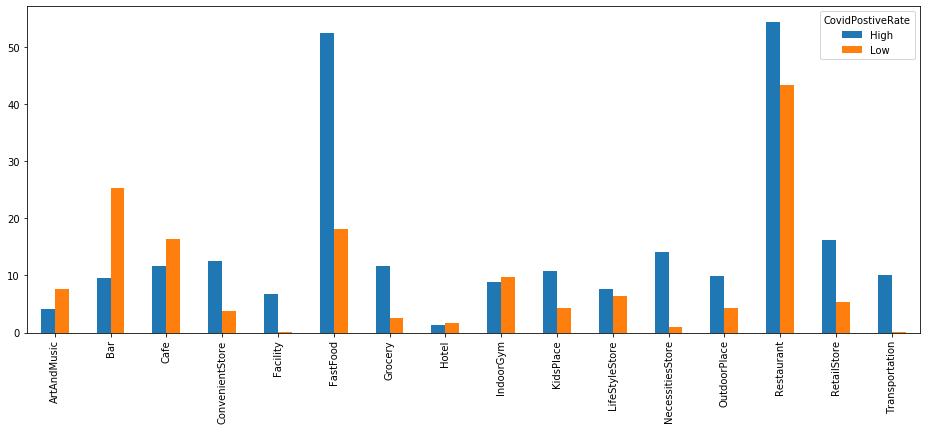

In [52]:
venue_plot = venue_matrix_averaged.set_index('CovidPostiveRate')
venue_plot.T.plot(kind="bar",figsize=(16, 6))

## Discussion

**Percentage of Senior** has no contribution to covid rates, while **youth ratio** is positive correlated with covid rates. I think the main difference between the two groups is their social activity modes. Young people have a higher possibility to go to a bar, a restaurant or a movie theater with a group of friends, while senior people are most likely to have relative quiet activities with their families in a relative private spot. More vulnerable to virus does not make senior people more easily to get the disease, but just after getting the virus, their possibility to have severe symptoms is higher. Also, young people, as students, also need to go to school. This situation also put them under a higher risk to get infected.

Neighborhood type is also correlated to covid positive rates. Residential type areas with more convenient stores, grocery stores, fast food restaurants seem to have higher covid rate, while the business districts have lower covid rate.


## Conclusion

This study briefly analyzed some possible covid correlated factors in the zip code areas in New York City. The data is showing correlation but not causality.